In [16]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd
import os
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


## Data Exploration

#### Reorganize train folder(each class store in one folder)

In [2]:
# Path to the images and the CSV file
images_dir = '/Users/77wu/Desktop/NNHW2F/train_images'
csv_file_path = 'train_data.csv'

# Read the CSV file into a DataFrame
train_df = pd.read_csv(csv_file_path)

# Iterate over the DataFrame and move each image to the appropriate folder
for index, row in train_df.iterrows():
    image_name = row['img_name']  # Assuming the column name is 'image_name'
    label = row['label']  # Assuming the column name is 'label'
    
    # Create the directory for the label if it doesn't exist
    label_dir = os.path.join(images_dir, str(label))
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
    
    # Move the image to the corresponding label directory
    source_path = os.path.join(images_dir, image_name)
    destination_path = os.path.join(label_dir, image_name)
    
    # Only move if the source file exists to avoid errors
    if os.path.exists(source_path):
        shutil.move(source_path, destination_path)
    else:
        print(f"Warning: {source_path} does not exist and cannot be moved.")

#### Preparing Data

In [39]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
import tensorflow as tf

batch_size = 32
img_height = 100
img_width = 100

# Load all images from the directory without splitting
data_dir = "/Users/77wu/Desktop/NNHW2F/train_images"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_image_filenames = [path.split('/')[-1] for path in train_ds.file_paths]
print(train_image_filenames)
print(len(train_image_filenames))


Found 22046 files belonging to 2 classes.
['C147P108ThinF_IMG_20151115_095606_cell_43.png', 'C112P73ThinF_IMG_20150930_131659_cell_69.png', 'C189P150ThinF_IMG_20151203_142224_cell_87.png', 'C100P61ThinF_IMG_20150918_150041_cell_76.png', 'C180P141NThinF_IMG_20151201_164714_cell_164.png', 'C188P149ThinF_IMG_20151203_134229_cell_216.png', 'C182P143NThinF_IMG_20151201_171836_cell_161.png', 'C133P94ThinF_IMG_20151004_155144_cell_114.png', 'C48P9thinF_IMG_20150721_161055_cell_188.png', 'C183P144NThinF_IMG_20151201_224107_cell_46.png', 'C226ThinF_IMG_20151112_131408_cell_220.png', 'C162P123ThinF_IMG_20151116_102655_cell_14.png', 'C126P87ThinF_IMG_20151004_104408_cell_168.png', 'C117P78ThinF_IMG_20150930_214629_cell_101.png', 'C180P141NThinF_IMG_20151201_165528_cell_175.png', 'C59P20thinF_IMG_20150803_112802_cell_175.png', 'C33P1thinF_IMG_20150619_114756a_cell_182.png', 'C39P4thinF_original_IMG_20150622_110435_cell_41.png', 'C51AP12thinF_IMG_20150724_162636_cell_30.png', 'C70P31_ThinF_IMG_2015

#### Visualize some cells from the train dataset

['0', '1']


2024-03-15 21:31:05.752143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


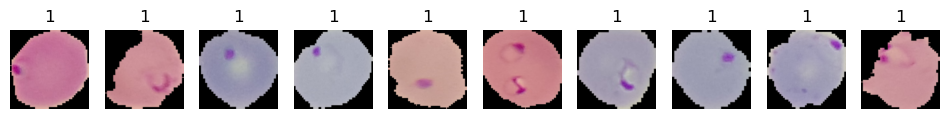

In [42]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
print(class_names)
max_images = 10
images_displayed = 0

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(len(labels)):
        if labels[i] == 1 and images_displayed < max_images:
            ax = plt.subplot(1, max_images, images_displayed + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            images_displayed += 1
        if images_displayed >= max_images:
            break


['0', '1']


2024-03-15 21:30:07.103819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


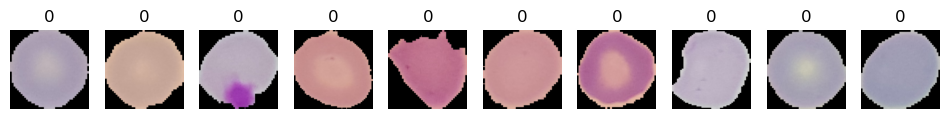

In [36]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
print(class_names)
max_images = 10
images_displayed = 0

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(len(labels)):
        if labels[i] == 0 and images_displayed < max_images:
            ax = plt.subplot(1, max_images, images_displayed + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            images_displayed += 1
        if images_displayed >= max_images:
            break


In [259]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 3)
(32,)


## Finding outliers
### 1. Extracting feature embeddings from the images using a pretrained ResNet50 model
#### Reference:https://docs.cleanlab.ai/stable/tutorials/outliers.html

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load ResNet50 model pre-trained on ImageNet for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features_from_dataset(dataset, model):
    features = []
    for images, _ in dataset:
        # Preprocess the images
        images_preprocessed = preprocess_input(images.numpy())
        # Extract features
        features_batch = model.predict(images_preprocessed)
        features.append(features_batch.reshape(features_batch.shape[0], -1))
    return np.vstack(features)

# Example usage for extracting features from the train_ds
train_features = extract_features_from_dataset(train_ds, model)

In [262]:
print("Shape of train_features:", train_features.shape)

Shape of train_features: (22046, 32768)
Shape of test_features: (5512, 32768)


In [36]:
import numpy as np
#np.save('/Users/77wu/Desktop/NNHW2F/train_features.npy', train_features)
train_features = np.load('/Users/77wu/Desktop/NNHW2F/train_features.npy')

In [40]:
# Collect labels from the train_ds
csv_file_path = '/Users/77wu/Desktop/NNHW2F/train_data.csv'
train = pd.read_csv(csv_file_path)
filename_to_label = {row['img_name']: row['label'] for _, row in train.iterrows()}
train_labels = [filename_to_label[filename] for filename in train_image_filenames]

train_df= pd.DataFrame({
    'features': list(train_features),  
    'label': train_labels,
    'img_name': train_image_filenames
})

# For Training Features
indices_train_label_0 = np.where(train_labels == 0)[0]
indices_train_label_1 = np.where(train_labels == 1)[0]

print(train_df.head())
print(len(train_df))


                                            features  label  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
2  [0.0, 0.0, 0.0, 0.88364017, 0.0, 0.0, 0.0, 0.0...      1   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
4  [0.0, 0.0, 0.030043185, 0.0, 0.0, 0.0, 0.0, 0....      1   

                                          img_name  
0    C147P108ThinF_IMG_20151115_095606_cell_43.png  
1     C112P73ThinF_IMG_20150930_131659_cell_69.png  
2    C189P150ThinF_IMG_20151203_142224_cell_87.png  
3     C100P61ThinF_IMG_20150918_150041_cell_76.png  
4  C180P141NThinF_IMG_20151201_164714_cell_164.png  
22046


In [41]:
features_label_1 = list(train_df[train_df['label'] == 1]['features'])
features_label_0 = list(train_df[train_df['label'] == 0]['features'])

features_label_1_array = np.array(features_label_1)
features_label_0_array = np.array(features_label_0)

print(len(features_label_1_array))
print(len(features_label_0_array))

11041
11005


### 2. Outlier Detection using Isolation Forest
#### Detect data points that deviate significantly from the majority of the data

In [42]:
from sklearn.ensemble import IsolationForest

def detect_outliers(features, contamination=0.01):  # Lower value makes it stricter
    isolation_forest = IsolationForest(n_estimators=100, contamination=contamination, random_state=77)
    outlier_predictions = isolation_forest.fit_predict(features)
    anomaly_scores = isolation_forest.decision_function(features)
    return outlier_predictions, anomaly_scores


# Detect outliers in each feature set
outlier_preds_1, anomaly_scores_1 = detect_outliers(features_label_1)
outlier_preds_0, anomaly_scores_0 = detect_outliers(features_label_0)

In [43]:
# Count outliers in each group
num_outliers_1 = (outlier_preds_1 == -1).sum()
num_outliers_0 = (outlier_preds_0 == -1).sum()

print(f"Number of outliers removed from label 1: {num_outliers_1}")
print(f"Number of outliers removed from label 0: {num_outliers_0}")


Number of outliers removed from label 1: 111
Number of outliers removed from label 0: 111


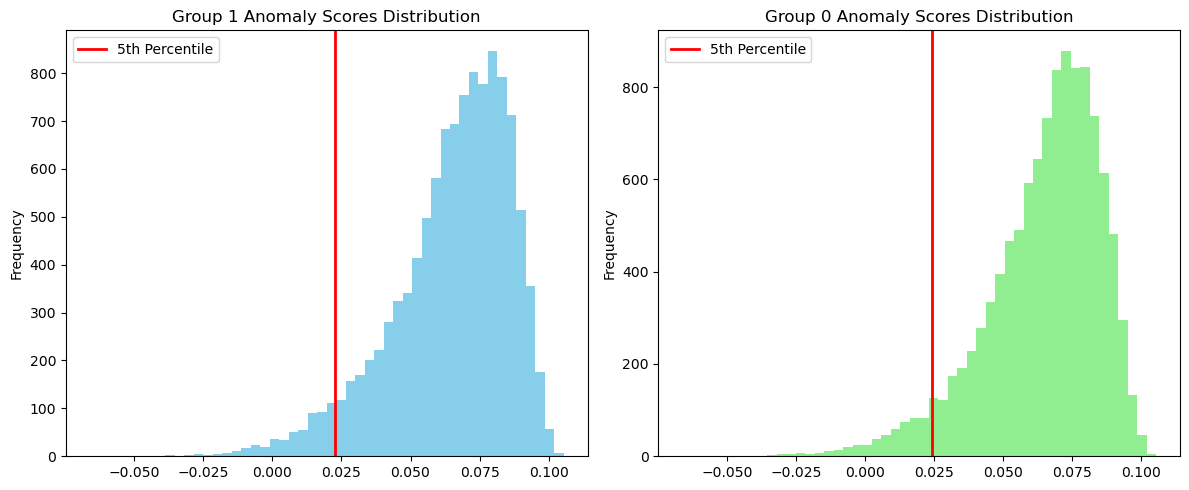

In [312]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the 5th percentile for anomaly scores from both groups
fifth_percentile_1 = np.percentile(anomaly_scores_1, 5)  # 5th percentile for group 1
fifth_percentile_0 = np.percentile(anomaly_scores_0, 5)  # 5th percentile for group 0

# Determine the range for plotting based on the min and max of both groups' scores
plt_range = [
    min(anomaly_scores_1.min(), anomaly_scores_0.min()),
    max(anomaly_scores_1.max(), anomaly_scores_0.max())
]

# Plot distributions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Group 1
axes[0].hist(anomaly_scores_1, range=plt_range, bins=50, color='skyblue')
axes[0].set(title='Group 1 Anomaly Scores Distribution', ylabel='Frequency')
axes[0].axvline(x=fifth_percentile_1, color='red', linewidth=2, label='5th Percentile')
axes[0].legend()

# Group 0
axes[1].hist(anomaly_scores_0, range=plt_range, bins=50, color='lightgreen')
axes[1].set(title='Group 0 Anomaly Scores Distribution', ylabel='Frequency')
axes[1].axvline(x=fifth_percentile_0, color='red', linewidth=2, label='5th Percentile')
axes[1].legend()

plt.tight_layout()
plt.show()


### 3. Identifying Top Outliers + Visualize + Remove/Swap

In [284]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random

def visualize_images(indices, image_names, base_path="/Users/77wu/Desktop/NNHW2F/train_images_ori/"):
    plt.figure(figsize=(10, 5))

    # Randomly select indices if there are more than 5 images
    if len(indices) > 5:
        chosen_indices = random.sample(list(indices), 5)
    else:
        chosen_indices = indices
    
    for i, idx in enumerate(chosen_indices):
        img_name = image_names[idx]
        img_path = f"{base_path}{img_name}"  # Construct the full image path
        img = image.load_img(img_path, target_size=(180, 180))  # Load the image
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


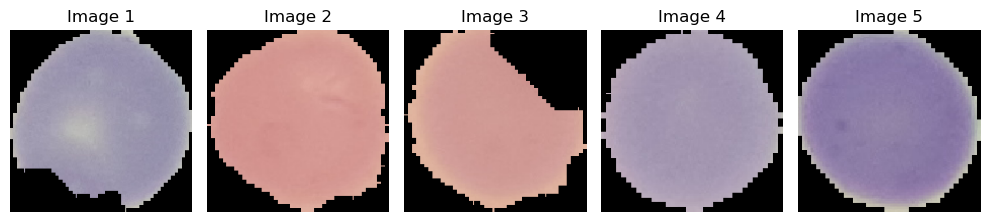

In [287]:
# Example: Visualize outliers in label_1: that should look like 0
outlier_indices_1 = np.where(outlier_preds_1 == -1)[0]
visualize_images(outlier_indices_1, train_image_filenames)

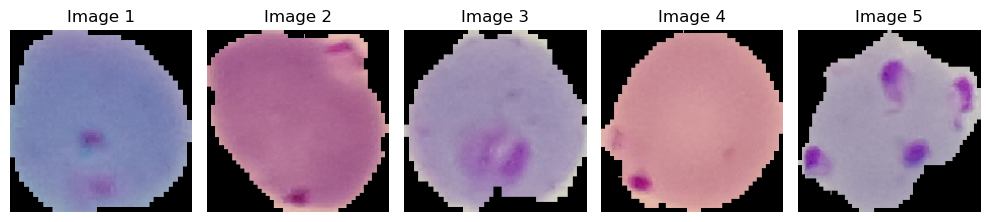

In [299]:
# Example: Visualize outliers in label_0: that should look like 1
outlier_indices_0 = np.where(outlier_preds_0 == -1)[0]
visualize_images(outlier_indices_0, train_image_filenames)

#### Remove outliers from the corresponding groups

In [44]:
inliers_features_label_1 = features_label_1_array[outlier_preds_1 == 1]
inliers_features_label_0 = features_label_0_array[outlier_preds_0 == 1]
combined_inliers_features = np.concatenate([inliers_features_label_0, inliers_features_label_1])

In [303]:
print(len(inliers_features_label_0))
print(len(inliers_features_label_1))
inliers_features_label_1

10894
10930


array([[0.        , 0.        , 0.        , ..., 0.9413171 , 0.6317936 ,
        0.        ],
       [0.        , 0.        , 0.03004318, ..., 0.        , 0.32523727,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.6302109 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.7855965 ,
        0.        ],
       [0.09364164, 0.        , 0.        , ..., 0.        , 3.2911143 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 3.0994058 ,
        1.069628  ]], dtype=float32)

#### Swap outliers label

In [45]:
combined_features = np.concatenate([features_label_0_array, features_label_1_array])
new_labels_label_0 = np.where(outlier_preds_0 == 0, 1, 0)  
new_labels_label_1 = np.where(outlier_preds_1 == 0, 0, 1) 
combined_labels = np.concatenate([new_labels_label_0, new_labels_label_1])

#### Convert the Cleaned Data back to csv with corresponding img_name and label

In [304]:
# Convert inlier features to strings for comparison
inliers_features_0_str = set([" ".join(map(str, feature)) for feature in inliers_features_label_0])
inliers_features_1_str = set([" ".join(map(str, feature)) for feature in inliers_features_label_1])
def feature_in_inliers(row_feature, inliers_features_0_str, inliers_features_1_str):
    # Convert row feature to string
    feature_str = " ".join(map(str, row_feature))
    # Check if this string is in the inlier feature strings
    return feature_str in inliers_features_0_str or feature_str in inliers_features_1_str

# Apply the function to filter rows in train_df
filtered_rows = train_df[train_df['features'].apply(lambda x: feature_in_inliers(x, inliers_features_0_str, inliers_features_1_str))]

print(filtered_rows.head())
print(len(filtered_rows))

                                            features  label  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
2  [0.0, 0.0, 0.0, 0.88364017, 0.0, 0.0, 0.0, 0.0...      0   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      1   
4  [0.0, 0.0, 0.030043185, 0.0, 0.0, 0.0, 0.0, 0....      1   

                                         img_name  
0  C156P117ThinF_IMG_20151115_154313_cell_122.png  
1    C58P19thinF_IMG_20150802_123134_cell_107.png  
2      C203ThinF_IMG_20151029_104112_cell_251.png  
3   C119P80ThinF_IMG_20151002_123911_cell_133.png  
4  C157P118ThinF_IMG_20151115_164026_cell_227.png  
21824


In [305]:
filtered_img_labels_df = filtered_rows[['img_name', 'label']]
print(filtered_img_labels_df.head())

csv_save_path = '/Users/77wu/Desktop/NNHW2F/filtered_img_labels.csv'
filtered_img_labels_df.to_csv(csv_save_path, index=False)

print(f"DataFrame saved to {csv_save_path}")


                                         img_name  label
0  C156P117ThinF_IMG_20151115_154313_cell_122.png      0
1    C58P19thinF_IMG_20150802_123134_cell_107.png      0
2      C203ThinF_IMG_20151029_104112_cell_251.png      0
3   C119P80ThinF_IMG_20151002_123911_cell_133.png      1
4  C157P118ThinF_IMG_20151115_164026_cell_227.png      1
DataFrame saved to /Users/77wu/Desktop/NNHW2F/filtered_img_labels.csv


## Load the CLEANED Dataset

In [5]:
# Path to the images and the CSV file
images_dir = '/Users/77wu/Desktop/NNHW2F/train_images_filtered'
csv_file_path = '/Users/77wu/Desktop/NNHW2F/filtered_img_labels.csv'

train_df = pd.read_csv(csv_file_path)
valid_images = set(train_df['img_name'])

for subdir, dirs, files in os.walk(images_dir):
    for file in files:
        # Check if the file is listed in the CSV
        if file in valid_images:
            # Find the label for the current file
            label = train_df[train_df['img_name'] == file]['label'].iloc[0]
            
            # Define source and destination paths
            source_path = os.path.join(subdir, file)
            label_dir = os.path.join(images_dir, str(label))
            destination_path = os.path.join(label_dir, file)
            
            # Create the label directory if it doesn't exist
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)
            
            # Move the file to the label directory
            shutil.move(source_path, destination_path)
        else:
            # If the file is not in the CSV, remove it
            os.remove(os.path.join(subdir, file))


In [51]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
import tensorflow as tf

batch_size = 32
img_height = 100
img_width = 100

data_dir = "/Users/77wu/Desktop/NNHW2F/train_images_filtered"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)


test_images_directory = '/Users/77wu/Desktop/NNHW2F/test_images'
test_ds = image_dataset_from_directory(
    directory=test_images_directory,
    labels=None,  
    label_mode=None,  
    color_mode='rgb',  
    batch_size=batch_size,  
    image_size=(img_height, img_width),
    shuffle=False)  

test_image_filenames = [path.split('/')[-1] for path in test_ds.file_paths]
print(test_image_filenames)
print(len(test_image_filenames))
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 21824 files belonging to 2 classes.
Found 5512 files.
['C100P61ThinF_IMG_20150918_144104_cell_167.png', 'C100P61ThinF_IMG_20150918_144104_cell_169.png', 'C100P61ThinF_IMG_20150918_144104_cell_65.png', 'C100P61ThinF_IMG_20150918_144348_cell_142.png', 'C100P61ThinF_IMG_20150918_144348_cell_25.png', 'C100P61ThinF_IMG_20150918_144348_cell_40.png', 'C100P61ThinF_IMG_20150918_144823_cell_160.png', 'C100P61ThinF_IMG_20150918_144823_cell_162.png', 'C100P61ThinF_IMG_20150918_144823_cell_21.png', 'C100P61ThinF_IMG_20150918_145042_cell_162.png', 'C100P61ThinF_IMG_20150918_145042_cell_81.png', 'C100P61ThinF_IMG_20150918_145042_cell_94.png', 'C100P61ThinF_IMG_20150918_145422_cell_167.png', 'C100P61ThinF_IMG_20150918_145422_cell_168.png', 'C100P61ThinF_IMG_20150918_145422_cell_21.png', 'C100P61ThinF_IMG_20150918_145609_cell_30.png', 'C100P61ThinF_IMG_20150918_145609_cell_75.png', 'C100P61ThinF_IMG_20150918_145938_cell_145.png', 'C100P61ThinF_IMG_20150918_145938_cell_168.png', 'C100P61ThinF_IMG

## Image Preprocessing 

### Model Split

In [49]:
total_batches = tf.data.experimental.cardinality(train_ds).numpy()
train_batches = int(total_batches * 0.8)
val_batches = total_batches - train_batches

# Split the dataset into training and validation sets
train_ds_subset = train_ds.take(train_batches)
val_ds_subset = train_ds.skip(train_batches)

print(f"Total batches: {total_batches}, Training batches: {train_batches}, Validation batches: {val_batches}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds_subset = train_ds_subset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_subset = val_ds_subset.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Total batches: 682, Training batches: 545, Validation batches: 137


### Normalized using mean and std (Before)

In [11]:
import tensorflow as tf
import numpy as np

# Initialize sums and square sums
psum = np.zeros(3)
psum_sq = np.zeros(3)

# Number of images processed
count = 0

for images, _ in train_ds:
    # Convert images to numpy arrays
    imgs_array = images.numpy()
    # Sum over batch, height, and width dimensions, keep the channel dimension
    psum += imgs_array.sum(axis=(0, 1, 2))
    psum_sq += (imgs_array ** 2).sum(axis=(0, 1, 2))
    # Update count (total number of pixels processed per channel)
    count += imgs_array.shape[0] * imgs_array.shape[1] * imgs_array.shape[2]

# Calculate mean and standard deviation per channel
mean = psum / count
std = np.sqrt((psum_sq / count) - (mean ** 2))

print('mean: ' + str(mean))
print('std:  ' + str(std))

def normalize_img(image, label):
    return (image - mean) / std, label

# Apply normalization to datasets
normalized_train_ds = train_ds_subset.map(normalize_img)
normalized_val_ds = val_ds_subset.map(normalize_img)

def normalize_img_test(image):
    return (image - mean) / std

normalized_test_ds = test_ds.map(normalize_img_test)


mean: [135.05042126 108.13338148 115.54942188]
std:  [85.82589906 69.43414254 73.33899734]


2024-03-16 14:05:30.088403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Normalize by 1/255 scaling pixel (Before)

In [9]:
def normalize_img255(image, label):
    return image / 255.0, label

def normalize_img255_test(image):
    return image / 255.0

# Apply normalization to training and testing datasets
normalized_train_ds255 = train_ds_subset.map(normalize_img255)
normalized_val_ds255 = val_ds_subset.map(normalize_img255)
normalized_test_ds255 = test_ds.map(normalize_img255_test)


## Create the model
#### Model Layer Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5907772/
#### Satuation Augmentation Reference: https://arxiv.org/pdf/2105.04128.pdf

In [10]:
class CustomNormalizationLayer(tf.keras.layers.Layer):
    def __init__(self, mean, std, **kwargs):
        super(CustomNormalizationLayer, self).__init__(**kwargs)
        # Ensure mean and std are stored as float32 tensors
        self.mean = tf.cast(mean, dtype=tf.float32)
        self.std = tf.cast(std, dtype=tf.float32)
    
    def call(self, inputs):
        # Use the stored mean and std, which are already float32 tensors
        mean = tf.reshape(self.mean, [1, 1, 1, -1])
        std = tf.reshape(self.std, [1, 1, 1, -1])
        return (inputs - mean) / std

    def get_config(self):
        config = super(CustomNormalizationLayer, self).get_config()
        # When saving the model, mean and std are converted to numpy arrays
        config.update({
            "mean": self.mean.numpy(),  # This will be a float32 numpy array
            "std": self.std.numpy(),    # This will be a float32 numpy array
        })
        return config

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


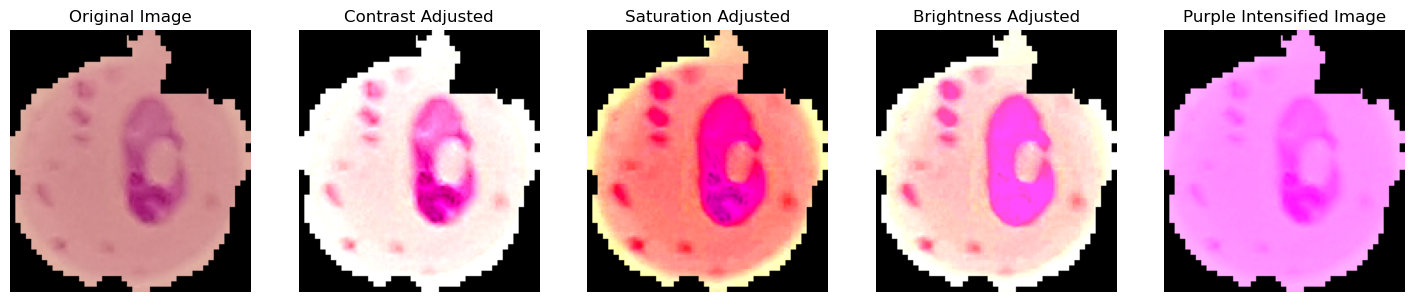

In [38]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the image
image_path = "/Users/77wu/Desktop/NNHW2F/test_images/C101P62ThinF_IMG_20150918_151942_cell_67.png"
image = tf.io.read_file(image_path)
image = tf.io.decode_png(image, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)

# Adjust contrast, brightness, and saturation
contrast_adjusted = tf.image.adjust_contrast(image, 3)  # Example contrast factor
saturation_adjusted = tf.image.adjust_saturation(contrast_adjusted, 2)  # Example saturation factor
brightness_adjusted = tf.image.adjust_brightness(saturation_adjusted, 0.3)  # Example brightness delta

def intensify_purple(image, factor=1.2):
    red, green, blue = image[..., 0], image[..., 1], image[..., 2]
    purple_mask = tf.minimum(red, blue) # This should be high where both red and blue are high
    red_intensified = red + (purple_mask * factor)
    blue_intensified = blue + (purple_mask * factor)
    red_intensified = tf.clip_by_value(red_intensified, 0.0, 1.0)
    blue_intensified = tf.clip_by_value(blue_intensified, 0.0, 1.0)
    intensified_image = tf.stack([red_intensified, green, blue_intensified], axis=-1)
    return intensified_image

purple_intensified_image = intensify_purple(image, factor=2)

# Plot the original and adjusted images
plt.figure(figsize=(18, 6))

plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(image.numpy())
plt.axis('off')

plt.subplot(1, 5, 2)
plt.title('Contrast Adjusted')
plt.imshow(contrast_adjusted.numpy())
plt.axis('off')

plt.subplot(1, 5, 3)
plt.title('Saturation Adjusted')
plt.imshow(saturation_adjusted.numpy())
plt.axis('off')

plt.subplot(1, 5, 4)
plt.title('Brightness Adjusted')
plt.imshow(brightness_adjusted.numpy())
plt.axis('off')

plt.subplot(1, 5, 5)
plt.title('Purple Intensified Image')
plt.imshow(purple_intensified_image)
plt.axis('off')

plt.show()


In [54]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Rescaling, Normalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda

def adjust_saturation(image, saturation_factor):
    return tf.image.adjust_saturation(image, saturation_factor)
saturation_layer = Lambda(lambda x: adjust_saturation(x, saturation_factor=2))

def adjust_contrast(image, contrast_factor):
    return tf.image.adjust_contrast(image, contrast_factor)
contrast_layer = Lambda(lambda x: adjust_contrast(x, contrast_factor=3))

def adjust_brightness(image, delta):
    return tf.image.adjust_brightness(image, delta)
brightness_layer = Lambda(lambda x: adjust_brightness(x, delta=0.3))

def intensify_purple(image):
    # Split the image into its component color channels
    red, green, blue = image[:, :, :, 0], image[:, :, :, 1], image[:, :, :, 2]
    intensify_factor = 1.2  
    red_intensified = red * intensify_factor
    blue_intensified = blue * intensify_factor
    red_intensified = tf.clip_by_value(red_intensified, 0.0, 1.0)
    blue_intensified = tf.clip_by_value(blue_intensified, 0.0, 1.0)
    intensified_image = tf.stack([red_intensified, green, blue_intensified], axis=-1)
    return intensified_image
purple_intensify_layer = Lambda(lambda x: intensify_purple(x))

In [55]:

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),  # Slightly increased rotation
    layers.RandomZoom(0.2),  # Slightly increased zoom
    contrast_layer,
    saturation_layer,
    brightness_layer
  ]
)
#normalization_layer = Normalization(mean=mean, variance=np.square(std))
#img_height, img_width = 100, 100
l2_reg = 1e-4  

model = Sequential([
    #Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    #CustomNormalizationLayer(mean=mean, std=std, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    Conv2D(32, kernel_size=(3, 3), strides=2),
    Activation('relu'),  # ReLU Activation 1
    MaxPooling2D(pool_size=(2, 2), strides=2),  # Max-Pooling 1
    
    Conv2D(32, kernel_size=(3, 3), strides=2),
    Activation('relu'),  # ReLU Activation 2
    MaxPooling2D(pool_size=(2, 2), strides=2),  # Max-Pooling 2

    Conv2D(64, kernel_size=(3, 3), strides=2),
    Activation('relu'),  # ReLU Activation 3
    MaxPooling2D(pool_size=(2, 2), strides=2),  # Max-Pooling 3

    Flatten(),

    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
    Activation('relu'),  # ReLU Activation 4
    Dropout(0.5),  # Dropout with a 50% rate

    # Output Layer
    Dense(1, activation='sigmoid')
])



/Users/77wu/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
for image_batch, labels_batch in normalized_train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 3)
(32,)


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.utils import CustomObjectScope

#keras.config.enable_unsafe_deserialization()
model = load_model('model_best2.keras')

#Customed optimizers
'''optimizer_adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer_sgd = SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
optimizer_sgd_nesterov = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizer_rmsprop = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
optimizer_adagrad = Adagrad(learning_rate=0.01, initial_accumulator_value=0.1, epsilon=1e-07)
optimizer_adamax = Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07)'''

learning_rate = 0.01  
momentum = 0.9        
optimizer_sgd = SGD(learning_rate=learning_rate, momentum=momentum)
model.compile(optimizer= optimizer_sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath="model_best2.keras",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch'  # Can be set to a specific number of batches
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)  
    else:
        new_lr = lr * tf.math.exp(-0.1)
        return float(new_lr.numpy()) 
    
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

epochs=10
history = model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=epochs,
    callbacks=[lr_scheduler, checkpoint_callback, early_stopping]  
)

## Results
### Screenshots of parts of the best approach

![Image 1](10.png)


No normalization: val_acc ~= 0.9284 - val_loss ~= 0.2301

Normalize before by mean&std: val_acc ~= 0.940 - val_loss ~= 0.1756 :)  ----------------------> Best Normalization
 
Normalize before by 1/255: val_acc ~= 0.932 - val_loss ~= 0.1978

Normalize within the model by mean&std: val_acc ~= 0.9373 - val_loss ~= 0.1747 

Normalize within the model by 1/255: val_acc ~= 0.9309 - val_loss ~= 0.1933

Augmentation on transformations: val_acc ~= 0.9583 - val_loss ~= 0.1703

Best CNN Layers: val_acc ~= 0.9536 - val_loss ~= 0.1363  -------------------------------------> Best CNN Layers

Best Optimizer SGD: val_acc ~= 0.9648 - val_loss ~= 0.1003 -----------------------------------> Best Optimizer 

Improve Initialization: val_acc : ~0.9778 - val_loss: ~0.0803

Augmentation with image properties: val_acc : ~0.9677 - val_loss: ~0.0603 --------------------> Best Augmentation 


## Submission 

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("model_best5.keras")

probabilities = model.predict(normalized_test_ds)
predicted_labels = np.argmax(probabilities, axis=1)


In [ ]:
label_counts = np.bincount(predicted_labels)

# Number of 0s and 1s
num_zeros = label_counts[0] if 0 < len(label_counts) else 0
num_ones = label_counts[1] if 1 < len(label_counts) else 0

num_zeros, num_ones
#(2711, 2801)
#(2783, 2729)low
#norm1(2831, 2681)low
#model9626(2836, 2676)) low
#9711 (2811, 2701) high
#model9755(2824, 2688)
#968 (2811, 2701) 
#model9701 (2821, 2691) low

In [ ]:
submission = pd.DataFrame({
    'img_name': test_image_filenames, 
    'label': predicted_labels
})

# Save to CSV
submission.to_csv('model9.csv', index=False)